<a href="https://colab.research.google.com/github/humamfa/TimeSeries_Apple/blob/main/Time_Series_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as od
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
od.download('https://www.kaggle.com/datasets/julienjta/twitter-mentions-volumes')
df = pd.read_csv('/content/twitter-mentions-volumes/dataset.csv')
df

Skipping, found downloaded files in "./twitter-mentions-volumes" (use force=True to force download)


,timestamp,Apple,Amazon,Salesforce,CVS,Facebook,Google,IBM,Coca-Cola,Pfizer,UPS
0,2015-02-26 21:42:53,104,57.0,11,0.0,53.0,35.0,7.0,8.0,3.0,2.0
1,2015-02-26 21:47:53,100,43.0,10,0.0,64.0,41.0,4.0,8.0,2.0,2.0
2,2015-02-26 21:52:53,99,55.0,3,0.0,49.0,32.0,14.0,5.0,2.0,4.0
3,2015-02-26 21:57:53,154,64.0,4,0.0,48.0,36.0,6.0,13.0,36.0,3.0
4,2015-02-26 22:02:53,120,93.0,9,0.0,22.0,32.0,1.0,22.0,8.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
15897,2015-04-23 02:27:53,44,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15898,2015-04-23 02:32:53,45,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15899,2015-04-23 02:37:53,48,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15900,2015-04-23 02:42:53,26,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.isnull().sum()

timestamp      0
Apple          0
Amazon        71
Salesforce     0
CVS           49
Facebook      69
Google        60
IBM            9
Coca-Cola     51
Pfizer        44
UPS           36
dtype: int64

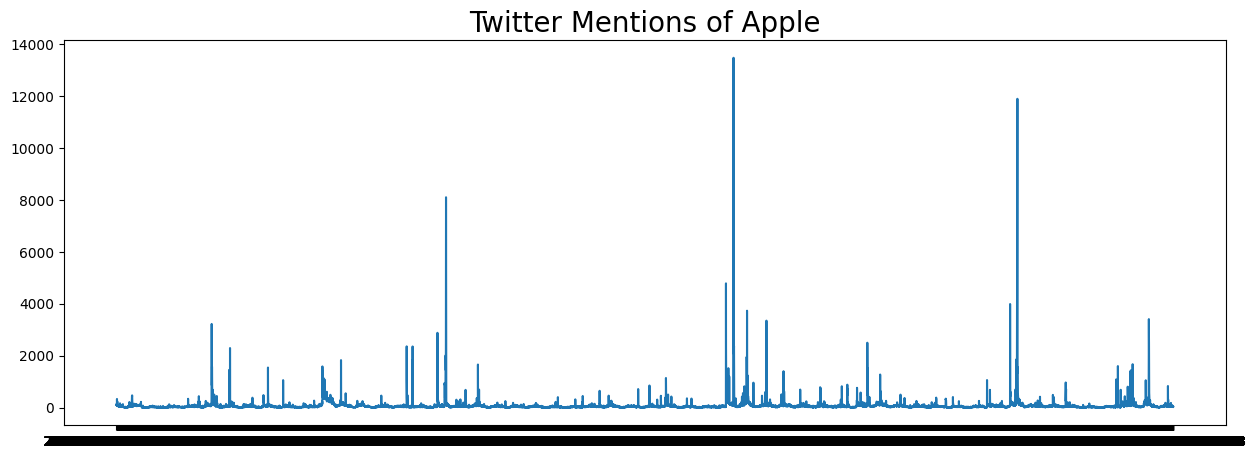

In [ ]:
time = df['timestamp'].values
value = df['Apple'].values

plt.figure(figsize=(15,5))
plt.plot(time, value)
plt.title('Twitter Mentions of Apple',
          fontsize=20);

In [ ]:
from sklearn.preprocessing import MinMaxScaler

value = value.reshape((len(value), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(value)

value_normal = scaler.transform(value)
value_array = np.array(value_normal)
value = value_array.flatten()
value

Min: 0.000000, Max: 13479.000000


array([0.00771571, 0.00741895, 0.00734476, ..., 0.00356109, 0.00192893,
       0.0028192 ], dtype=float32)

In [ ]:
value = value.astype("float32")

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
time_latih, time_test, value_latih, value_test = train_test_split(time, value, test_size=0.2, shuffle=False)

In [ ]:
print(value_latih)
print(len(value_latih))

[0.00771571 0.00741895 0.00734476 ... 0.00289339 0.00482232 0.00333853]
12721


In [ ]:
print(value_test)
print(len(value_test))

[0.00393204 0.00445137 0.00370947 ... 0.00356109 0.00192893 0.0028192 ]
3181


In [ ]:
train_set = windowed_dataset(value_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(value_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
threshold_mae = (value.max() - value.min()) * 10/100
threshold_mae

0.09999999403953552

In [ ]:
type(threshold_mae)

numpy.float64

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_train_end(self, logs={}):
    if(logs.get('val_mae') < threshold_mae):
      print("\nMAE kurang dari threshold!")
callbacks = myCallback()

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    validation_data=test_set,
                    epochs=3,
                    callbacks=[callbacks]
                    )

Epoch 1/3
127/127 [==============================] - 46s 280ms/step - loss: 1.8552e-04 - mae: 0.0043 - val_loss: 5.9758e-04 - val_mae: 0.0049
Epoch 2/3
127/127 [==============================] - 20s 153ms/step - loss: 1.8067e-04 - mae: 0.0041 - val_loss: 5.8778e-04 - val_mae: 0.0049
Epoch 3/3
127/127 [==============================] - 20s 153ms/step - loss: 1.7835e-04 - mae: 0.0041 - val_loss: 5.7818e-04 - val_mae: 0.0052

MAE kurang dari threshold!


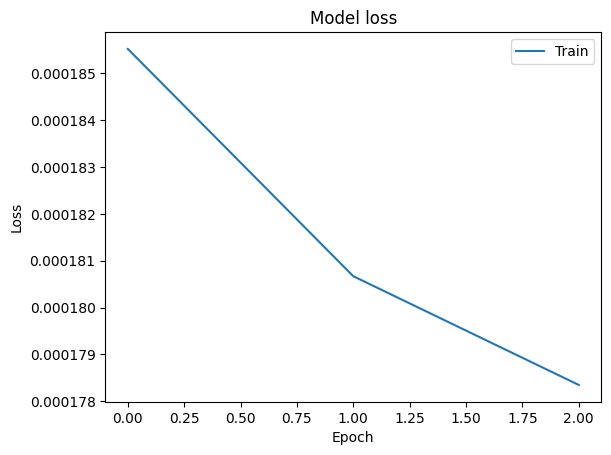

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

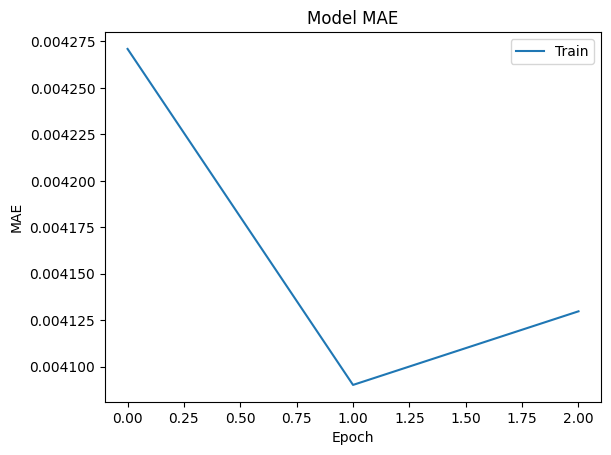

In [ ]:
plt.plot(history.history['mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()